# Explore "Verified_Annotation/" data

In [1]:
# Get parent directory
if 'parent_dir' not in globals():
    import os
    current_dir = os.getcwd()
    parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
parent_dir

'/Users/sglee/work/git/linc/LINC-detector'

In [2]:
cd $parent_dir

/Users/sglee/work/git/linc/LINC-detector


### Arguments

In [6]:
ROOT = 'datasets/Verified_Annotation'
VERT_SIZE = 500
# DPI = 400
DPI = 100

# Filters
def ignore_picture(objects):
    return False
    # labels = set(o['name'] for o in objects)
    # if not('ws' in labels):
    #     return True
    # return False

def filter_objects(objects):
    # Filter markings
    objects = [o for o in objects if not('marking' in o['name'])]
    return objects

### Code

In [4]:
import os
import xml.etree.ElementTree as ET
import collections
from PIL import Image, ImageDraw
from matplotlib.pyplot import figure, imshow, show
import matplotlib

import numpy as np
%matplotlib inline


def parse_voc_xml(node):
    voc_dict = {}
    children = list(node)
    if children:
        def_dic = collections.defaultdict(list)
        for dc in map(parse_voc_xml, children):
            for ind, v in dc.items():
                def_dic[ind].append(v)
        voc_dict = {
            node.tag:
                {ind: v[0] if len(v) == 1 else v
                 for ind, v in def_dic.items()}
        }
    if node.text:
        text = node.text.strip()
        if not children:
            voc_dict[node.tag] = text
    return voc_dict

def draw_boxes(image, objects):
    hor_size = image.size[1]
    scale_factor = VERT_SIZE / image.size[1]
    new_width = image.size[0] * scale_factor
    image = image.resize((int(new_width), int(VERT_SIZE)), Image.ANTIALIAS)
    draw = ImageDraw.Draw(image)

    labels_found = set()
    for o in objects:
        box = o['bndbox']
        box = scale_factor * np.array(
            [float(box['xmin']), float(box['ymin']),
             float(box['xmax']), float(box['ymax'])]
        )
        draw.rectangle(
            ((box[0], box[1]), (box[2], box[3])),
             outline='red', width=2
        )
        label = str(o['name'])
        draw.text((box[0], box[1]), label)
        labels_found.add(label)
    print(labels_found)
    return image




datasets/Verified_Annotation/Kope/LAG-B_Sandet_m/LAG-B_20140517_(1).xml
Image number: 1
(2564, 2424)
{'nose-sr', 'eye-sr', 'cv-sr', 'ear-sr', 'whisker-sr'}


/Users/sglee/anaconda3/envs/linc-detector-jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


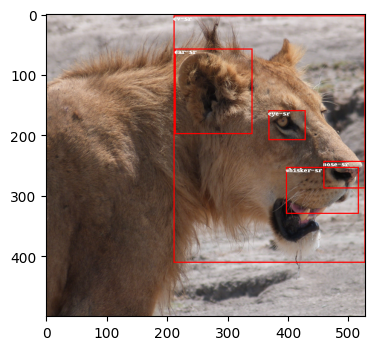

In [7]:
# This can't be set on the previous cell for'reasons'
matplotlib.rcParams['figure.dpi'] = DPI

# Iterate over .xml files
num_picture = 1
max_num_picture = 1 # max pictures to be displayed
for root, dirs, files in os.walk(ROOT):
    dirs.sort()
    for file_name in [os.path.join(root, f) for f in files]:
        if num_picture > max_num_picture:
            break
        if os.path.splitext(file_name)[1] == '.xml':
            # Get objects
            data = parse_voc_xml(ET.parse(file_name).getroot())
            try:
                objects = data['annotation']['object']
            except KeyError:
                objects = []
            objects = objects if type(objects) is list else [objects]
            
            # Apply some filters
            if ignore_picture(objects): continue
            objects = filter_objects(objects)
            
            # Display data
            print('\n\n')
            print(file_name)
            print(f"Image number: {num_picture}")
            
            image_path = os.path.join(root, data['annotation']['filename'])
            image_name = os.path.basename(image_path)
            image = Image.open(image_path)
            print(image.size)
            image_with_boxes = draw_boxes(image, objects)
            figure()
            imshow(np.asarray(image_with_boxes))
            show()
            num_picture += 1